In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# BLOCK 1: SETUP - Import Libraries & Define Functions
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.linear_model import RANSACRegressor, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from scipy.spatial import KDTree
from sklearn.cluster import DBSCAN


def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def show_image(image, title="Image", cmap=None):
    plt.figure(figsize=(6, 6))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()



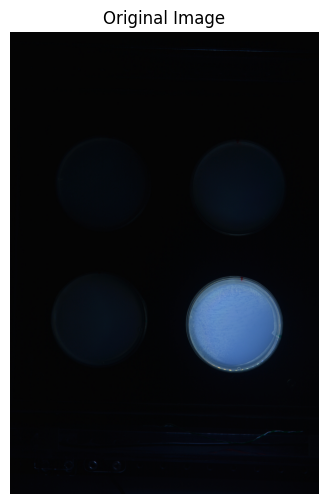

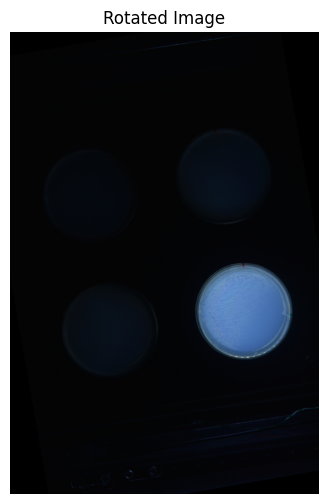

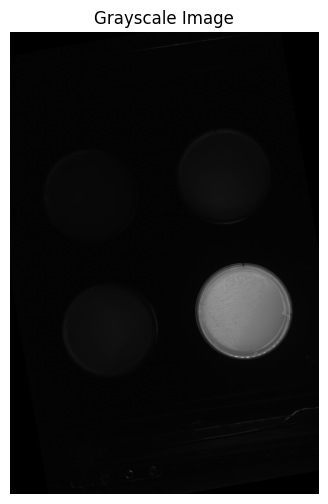

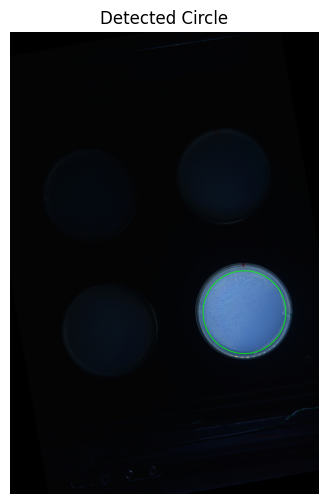

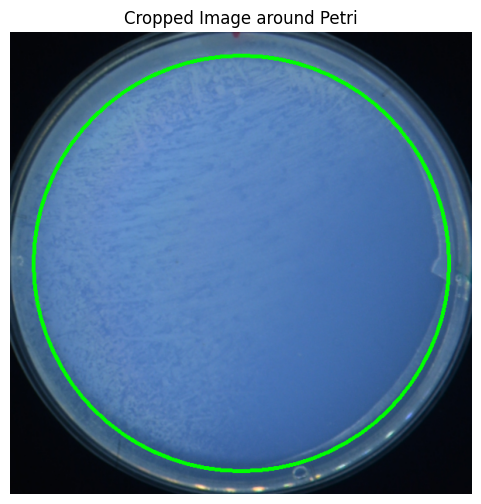

In [84]:
# BLOCK 2: Load, Rotate & Crop the Image Using Hough Circles

image_path = '/content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri0_0020_03.Apr.2025_03.57.17.jpg'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image file does not exist at {image_path}")

show_image(image, "Original Image")

# Rotate Image by 5 degrees (adjust based on your data)
rotated_image = rotate_image(image, 10)
show_image(rotated_image, "Rotated Image")


# Convert to grayscale
gray_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
show_image(gray_image, "Grayscale Image", cmap='gray')

# Detect circles (Petri dish)
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.1, minDist=500,
                           param1=90, param2=30, minRadius=60, maxRadius=300)

if circles is None:
    raise ValueError("No circles detected.")

circles = np.round(circles[0, :]).astype("int")
x, y, r = circles[0]
cv2.circle(rotated_image, (x, y), r-30, (0, 255, 0), 4)
show_image(rotated_image, "Detected Circle")

# Crop tightly around Petri dish
cropped_image = rotated_image[max(y-r,0):y+r, max(x-r,0):x+r]
show_image(cropped_image, "Cropped Image around Petri")


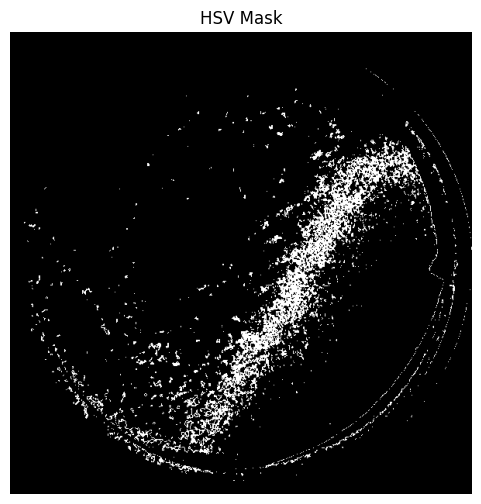

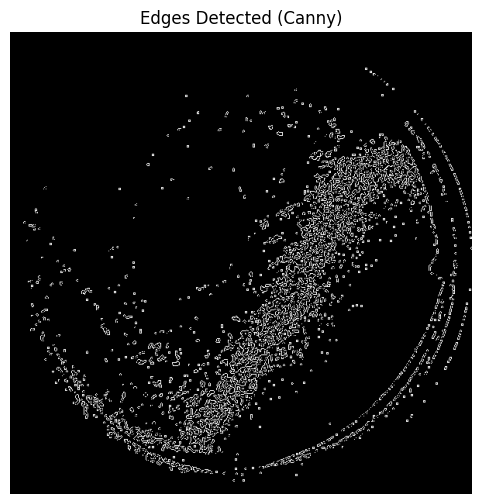

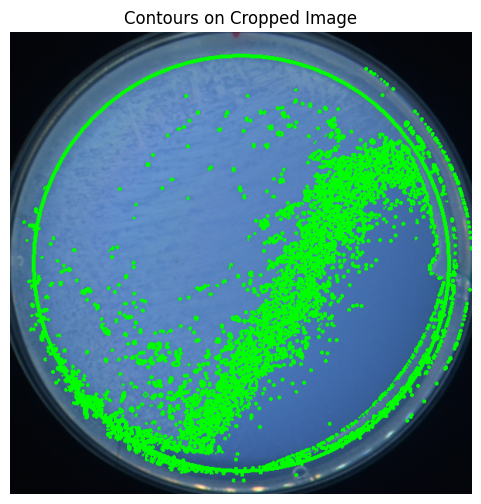

In [88]:
# BLOCK 3: HSV Masking and Contour Detection

hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

# Adjust HSV values for your specific setup (these are placeholders)

lower_hsv= np.array([105, 145, 120])
upper_hsv = np.array([120, 149, 255])

#lower_hsv = np.array([100, 140, 115])
#upper_hsv = np.array([108, 146, 255])

#lower_hsv = np.array([98, 135, 115])
#upper_hsv = np.array([110, 150, 255])

#lower_hsv = np.array([110, 150, 125])
#upper_hsv = np.array([118, 155, 255])

#lower_hsv = np.array([98, 138, 110])
#upper_hsv = np.array([127, 163, 255])


mask = cv2.inRange(hsv_image, lower_hsv, upper_hsv)
show_image(mask, "HSV Mask", cmap='gray')

# Edge detection
edges = cv2.Canny(mask, 50, 100)
show_image(edges, "Edges Detected (Canny)", cmap='gray')

# Contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cropped_image.copy()
cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)
show_image(contour_img, "Contours on Cropped Image")


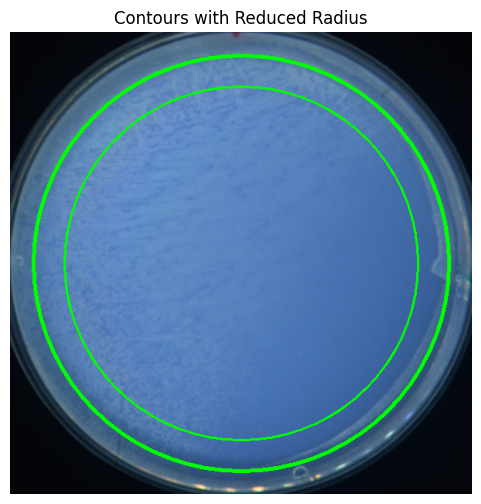

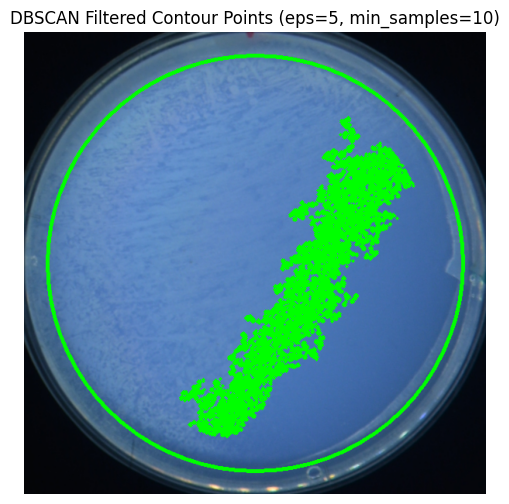

In [89]:
# BLOCK 4: Filtering out Non-lawn contour points
# Visual check: show reduced-radius circle
reduced_contour_img = cropped_image.copy()
radius_reduction = 70
cv2.circle(reduced_contour_img, (r, r), r - radius_reduction, (0, 255, 0), 2)
show_image(reduced_contour_img, "Contours with Reduced Radius")

# Stack all contour points
contour_points = np.vstack(contours).squeeze()

# Remove points outside the reduced radius
center = np.array([r, r])  # center of cropped image (assuming square)
distances = np.linalg.norm(contour_points - center, axis=1)
within_radius_mask = distances < (r - radius_reduction)
radius_filtered_points = contour_points[within_radius_mask]

# DBSCAN (Density-based spatial clustering) to remove colonies (sparse, isolated points)
distance_threshold = 5
min_samples = 10
db = DBSCAN(eps=distance_threshold, min_samples=min_samples).fit(radius_filtered_points)
labels = db.labels_


# Get only the largest cluster (excluding noise: label = -1)
unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
if len(unique_labels) == 0:
    print("No clusters found with DBSCAN.")
    largest_cluster_mask = labels != -1  # fallback: use all non-noise
else:
    main_cluster_label = unique_labels[np.argmax(counts)]
    largest_cluster_mask = labels == main_cluster_label

# Final filtered points
final_filtered_points = radius_filtered_points[largest_cluster_mask]

#Display
overlay_img = cropped_image.copy()
for pt in final_filtered_points:
    cv2.circle(overlay_img, tuple(pt.astype(int)), 2, (0, 255, 0), -1)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.title(f"DBSCAN Filtered Contour Points (eps={distance_threshold}, min_samples={min_samples})")
plt.axis('off')
plt.show()


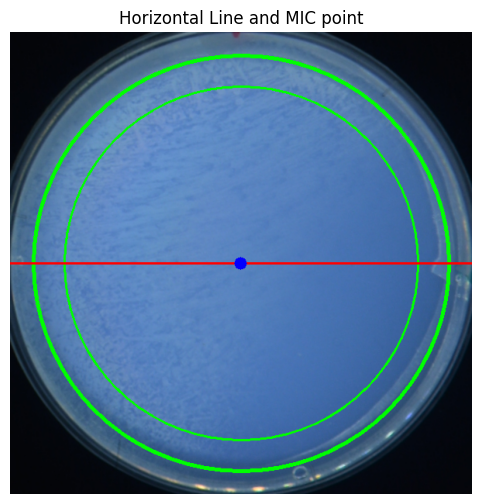

MIC (proportion): 0.502


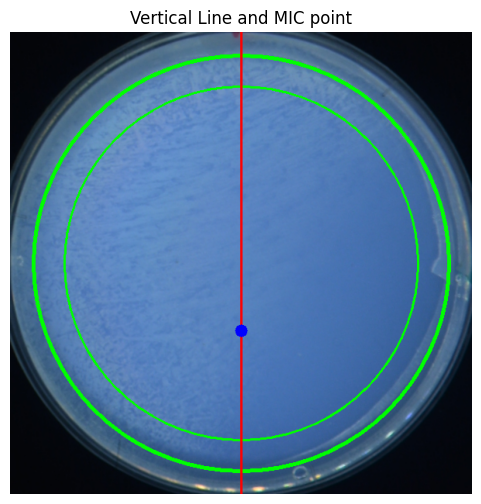

MIC_y: 10.34 ug/mL
MIC_x: 14.65 ug/mL


In [90]:
# BLOCK 5: Calculating MIC

mid_y = cropped_image.shape[0] // 2
tolerance = 2
horizontal_line_img = reduced_contour_img.copy()
cv2.line(horizontal_line_img, (0, mid_y), (cropped_image.shape[1], mid_y), (0,0,255), 2)

# Extract coordinates of contours
contour_points_x = np.vstack(final_filtered_points).squeeze()
midline_points_x = contour_points_x[np.abs(contour_points_x[:, 0] - mid_y) < tolerance]

if len(midline_points_x) > 0:
    breakthrough_x = np.min(midline_points_x[:,0])
else:
    breakthrough_x = np.min(contour_points_x[:,0])

total_length = cropped_image.shape[1]
MIC_position_x = breakthrough_x

cv2.circle(horizontal_line_img, (MIC_position_x, mid_y), 8, (255,0,0), -1)
show_image(horizontal_line_img, "Horizontal Line and MIC point")

MIC_value_x = (total_length - MIC_position_x) / total_length
print(f"MIC (proportion): {MIC_value_x:.3f}")


#calculating second MIC for double gradient plates
mid_x = cropped_image.shape[1] // 2
vertical_line_img = reduced_contour_img.copy()
cv2.line(vertical_line_img, (mid_x, 0), (mid_x, cropped_image.shape[0]), (0,0,255), 2)

# Extract coordinates of contours
contour_points_y = np.vstack(final_filtered_points).squeeze()
midline_points_y = contour_points_y[np.abs(contour_points_y[:, 0] - mid_x) < tolerance]

if len(midline_points_y) > 0:
    breakthrough_y = np.min(midline_points_y[:,1])
else:
    breakthrough_y = np.min(contour_points_y[:,1])

total_length = cropped_image.shape[1]
MIC_position_x = breakthrough_x
MIC_position_y = breakthrough_y

cv2.circle(vertical_line_img, (mid_x, MIC_position_y), 8, (255,0,0), -1)

show_image(vertical_line_img, "Vertical Line and MIC point")

MIC_value_y = (total_length - MIC_position_y) / total_length

#with maximum concentration
max_conc_x = 29.2
max_conc_y = 29.2
mic_x = MIC_value_x*max_conc_x
mic_y = MIC_value_y * max_conc_y
print(f"MIC_y: {mic_y:.2f} ug/mL")
print(f"MIC_x: {mic_x:.2f} ug/mL")


MIC_y: 10.34 ug/mL
MIC_x: 14.65 ug/mL


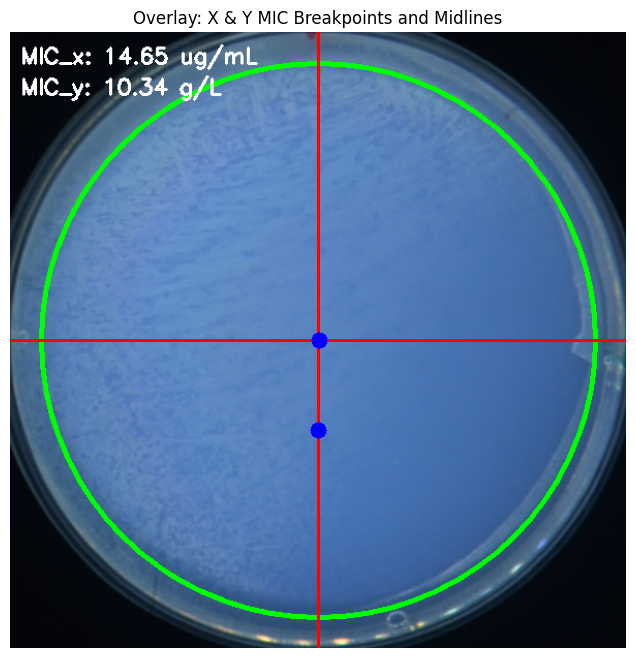

In [91]:
#Overlaying both MICs for double gradient plate plots
# Start with a fresh copy of the cropped image
overlay_image = cropped_image.copy()
# Define direction
drug_direction_x = 'right'  # 'left' or 'right'
drug_direction_y = 'top'    # 'top' or 'bottom'
# Draw red midlines
mid_x = cropped_image.shape[1] // 2
mid_y = cropped_image.shape[0] // 2
cv2.line(overlay_image, (0, mid_y), (cropped_image.shape[1], mid_y), (0, 0, 255), 2)  # Horizontal line
cv2.line(overlay_image, (mid_x, 0), (mid_x, cropped_image.shape[0]), (0, 0, 255), 2)  # Vertical line

# Horizontal MIC
if len(midline_points_x) > 0:
    if drug_direction_x == 'right':
        breakthrough_x = np.max(midline_points_x[:, 0])  # point furthest to the left
        MIC_value_x = (total_length - breakthrough_x) / total_length
    else:
        breakthrough_x = np.max(midline_points_x[:, 0])  # point furthest to the right
        MIC_value_x = breakthrough_x / total_length
else:
    breakthrough_x = np.min(contour_points_x[:, 0])
    MIC_value_x = (total_length - breakthrough_x) / total_length

# Draw MIC breakthrough points (in pink)
if 'breakthrough_x' in locals():
    cv2.circle(overlay_image, (breakthrough_x, mid_y), 8, (255, 0, 0), -1)  # X-axis MIC
if 'breakthrough_y' in locals():
    cv2.circle(overlay_image, (mid_x, breakthrough_y), 8, (255, 0, 0), -1)  # Y-axis MIC

# Annotate MIC values on the image
MIC_value_x = (total_length - MIC_position_x) / total_length
MIC_value_y = (total_length - MIC_position_y) / total_length

#with maximum concentration
max_conc_x = 29.2
max_conc_y = 29.2
mic_x = MIC_value_x*max_conc_x
mic_y = MIC_value_y * max_conc_y
print(f"MIC_y: {mic_y:.2f} ug/mL")
print(f"MIC_x: {mic_x:.2f} ug/mL")
mic_text_x = f"MIC_x: {mic_x:.2f} ug/mL"
mic_text_y = f"MIC_y: {mic_y:.2f} g/L"
cv2.putText(overlay_image, mic_text_x, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
cv2.putText(overlay_image, mic_text_y, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Show the result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title("Overlay: X & Y MIC Breakpoints and Midlines")
plt.axis('off')
plt.show()

MIC_x: 0.58 µg/mL
MIC_y: 0.68 µg/mL
MIC_value_x: 0.64
MIC_value_y: 0.73


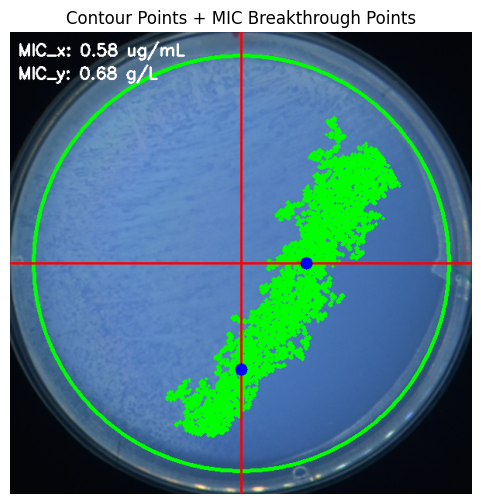

In [92]:
#TEST: OVERLAY MIC ONTO CONTOUR POINTS

# Configuration
drug_direction_x = 'right'  # or 'left'
drug_direction_y = 'top'    # or 'bottom'
tolerance = 15

# Setup
overlay_img = cropped_image.copy()
total_width = cropped_image.shape[1]
total_height = cropped_image.shape[0]
mid_y = total_height // 2
mid_x = total_width // 2

# Draw all final contour points
for pt in final_filtered_points:
    cv2.circle(overlay_img, tuple(pt.astype(int)), 2, (0, 255, 0), -1)  # green points

# Draw MIC midlines
cv2.line(overlay_img, (0, mid_y), (total_width, mid_y), (0, 0, 255), 2)   # horizontal (x MIC)
cv2.line(overlay_img, (mid_x, 0), (mid_x, total_height), (0, 0, 255), 2)  # vertical (y MIC)

# --- MIC X Calculation ---
contour_points_x = np.vstack(final_filtered_points).squeeze()
midline_points_x = contour_points_x[np.abs(contour_points_x[:, 1] - mid_y) < tolerance]

if len(midline_points_x) > 0:
    if drug_direction_x == 'right':
        breakthrough_x = np.median(midline_points_x[:, 0])  # Leftmost point
        MIC_value_x = (total_width - breakthrough_x) / total_width
    else:
        breakthrough_x = np.max(midline_points_x[:, 0])  # Rightmost
        MIC_value_x = breakthrough_x / total_width
else:
    breakthrough_x = np.min(contour_points_x[:, 0])
    MIC_value_x = (total_width - breakthrough_x) / total_width

cv2.circle(overlay_img, (int(breakthrough_x), mid_y), 8, (255, 0, 0), -1)

# --- MIC Y Calculation ---
contour_points_y = np.vstack(final_filtered_points).squeeze()
midline_points_y = contour_points_y[np.abs(contour_points_y[:, 0] - mid_x) < tolerance]

if len(midline_points_y) > 0:
    if drug_direction_y == 'top':
        breakthrough_y = np.median(midline_points_y[:, 1])
        MIC_value_y = (total_height - breakthrough_y) / total_height
    else:
        breakthrough_y = np.max(midline_points_y[:, 1])
        MIC_value_y = breakthrough_y / total_height
else:
    breakthrough_y = np.min(contour_points_y[:, 1])
    MIC_value_y = (total_height - breakthrough_y) / total_height

# Optional: Convert to ug/mL
max_conc_x = 0.9
max_conc_y = 2.5
mic_x = (1 - MIC_value_x) * max_conc_x
mic_y = (MIC_value_y) * max_conc_y
mic_text_x = f"MIC_x: {mic_x:.2f} ug/mL"
mic_text_y = f"MIC_y: {mic_y:.2f} g/L"
print(f"MIC_x: {mic_x:.2f} µg/mL")
print(f"MIC_y: {mic_y:.2f} µg/mL")
print(f"MIC_value_x: {(1-MIC_value_x):.2f}")
print(f"MIC_value_y: {(1-MIC_value_y):.2f}")
cv2.circle(overlay_img, (mid_x, int(breakthrough_y)), 8, (255, 0, 0), -1)
cv2.putText(overlay_img, mic_text_x, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
cv2.putText(overlay_img, mic_text_y, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Show results
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.title("Contour Points + MIC Breakthrough Points")
plt.axis('off')
plt.show()

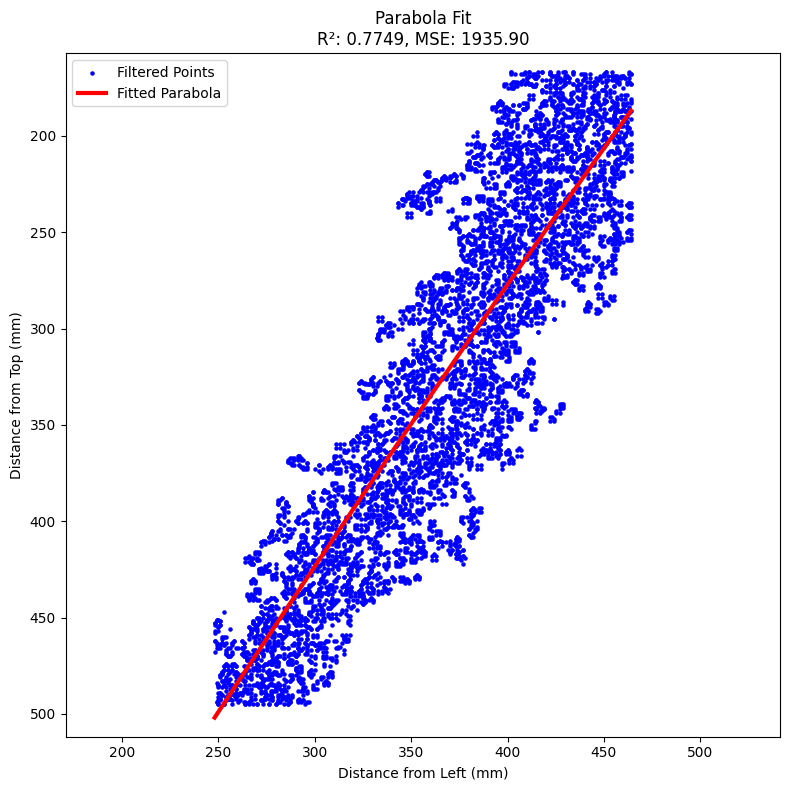

Quadratic coefficient (a): 0.0003 → no significant curvature
Linear coefficient (b): -1.6872 → negative linear shift (reducing effect)
Intercept (c): 900.5005
Equation of fitted parabola: y = 0.0003x² + -1.6872x + 900.5005
Overall interaction type: primarily linear interaction (negative linear shift (reducing effect))
Fit statistics: R²: 0.7749, MSE: 1935.90


In [93]:
# BLOCK 6: Parabolic Curve Fitting
x_coords = final_filtered_points[:, 0]
y_coords = final_filtered_points[:, 1]

# Filter out extreme values along Y-axis to focus on central contour
x_mask = (x_coords > np.percentile(x_coords, 5)) & (x_coords < np.percentile(x_coords, 95))
y_mask = (y_coords > np.percentile(y_coords, 5)) & (y_coords < np.percentile(y_coords, 95))
mask = x_mask & y_mask
x_filtered = x_coords[mask]
y_filtered = y_coords[mask]

# Fit parabola using RANSAC + Ridge Regression
model = make_pipeline(
    PolynomialFeatures(2),
    RANSACRegressor(
        min_samples=0.5,
        residual_threshold=10,
        random_state=42
    )
)
model.fit(x_filtered[:, np.newaxis], y_filtered)

# Generate smooth curve to plot
x_curve = np.linspace(np.min(x_filtered), np.max(x_filtered), 500)
y_curve = model.predict(x_curve[:, np.newaxis])

# Compute metrics
r2 = r2_score(y_filtered, model.predict(x_filtered[:, np.newaxis]))
mse = mean_squared_error(y_filtered, model.predict(x_filtered[:, np.newaxis]))

# Set up rounded axes with padding
x_min = np.floor(np.min(x_filtered) / 50) * 50
x_max = np.ceil(np.max(x_filtered) / 50) * 50
y_min = np.floor(np.min(y_filtered) / 50) * 50
y_max = np.ceil(np.max(y_filtered) / 50) * 50

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(x_filtered, y_filtered, s=5, color='blue', label='Filtered Points')
plt.plot(x_curve, y_curve, color='red', linewidth=3, label='Fitted Parabola')

plt.title(f'Parabola Fit\nR²: {r2:.4f}, MSE: {mse:.2f}')
plt.xlabel("Distance from Left (mm)")
plt.ylabel("Distance from Top (mm)")
plt.legend()

# Axis fixes
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(np.arange(x_min, x_max + 1, 50))
plt.yticks(np.arange(y_min, y_max + 1, 50))
plt.gca().invert_yaxis()  # To keep y = top-to-bottom
plt.axis('equal')         # Ensure circle-like shape consistency
plt.tight_layout()
plt.show()

# Print fitted equation + stats
coefs = model.named_steps['ransacregressor'].estimator_.coef_
intercept = model.named_steps['ransacregressor'].estimator_.intercept_

# Coefficients from model
coefs = model.named_steps['ransacregressor'].estimator_.coef_
intercept = model.named_steps['ransacregressor'].estimator_.intercept_
a = coefs[2]  # Quadratic
b = coefs[1]  # Linear
c= intercept

# Adjust thresholds if needed
quad_threshold = 1e-2
lin_threshold = 1e-2

# Inverted Y-axis interpretation
if abs(a) < quad_threshold:
    quad_interaction = "no significant curvature"
elif a > 0:
    quad_interaction = "antagonistic curvature (umbrella-shaped)"  # ✅ inverted interpretation
else:
    quad_interaction = "synergistic curvature (valley-shaped)"     # ✅ inverted interpretation

# Linear term interpretation remains the same
if abs(b) < lin_threshold:
    lin_interaction = "no significant linear shift"
elif b > 0:
    lin_interaction = "positive linear shift (enhancing effect)"
else:
    lin_interaction = "negative linear shift (reducing effect)"

# Combined interpretation
if abs(a) < quad_threshold and abs(b) < lin_threshold:
    interaction_type = "purely additive (no significant interaction)"
elif abs(a) < quad_threshold:
    interaction_type = f"primarily linear interaction ({lin_interaction})"
elif abs(b) < lin_threshold:
    interaction_type = f"primarily quadratic interaction ({quad_interaction})"
else:
    interaction_type = f"mixed interaction ({quad_interaction}, {lin_interaction})"

# Print corrected interpretation
print(f"Quadratic coefficient (a): {a:.4f} → {quad_interaction}")
print(f"Linear coefficient (b): {b:.4f} → {lin_interaction}")
print(f"Intercept (c): {intercept:.4f}")
print(f"Equation of fitted parabola: y = {a:.4f}x² + {b:.4f}x + {intercept:.4f}")
print(f"Overall interaction type: {interaction_type}")
print(f"Fit statistics: R²: {r2:.4f}, MSE: {mse:.2f}")

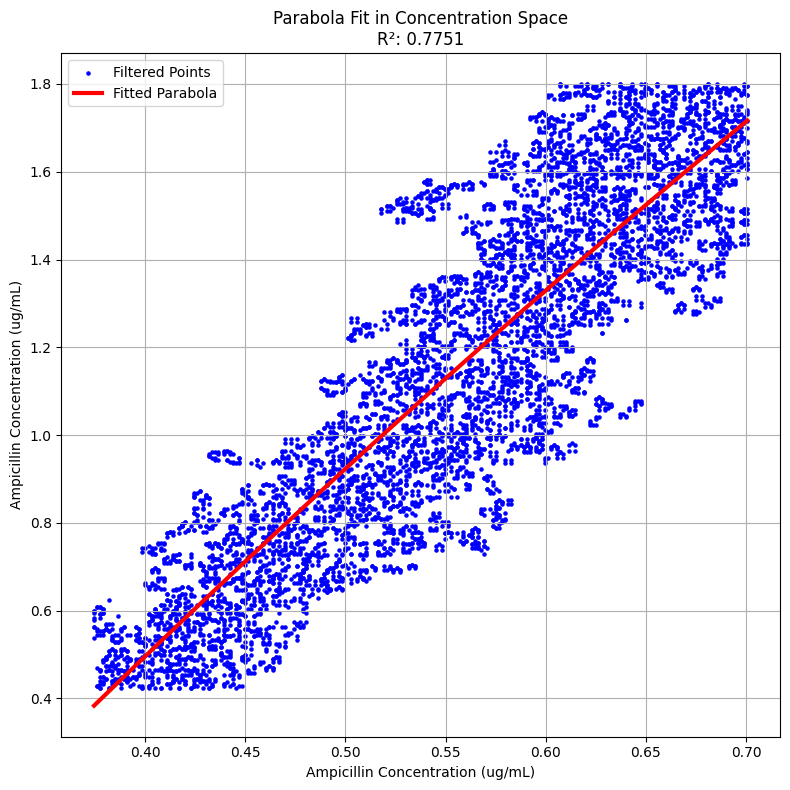


--- Parabola Fit in Concentration Space ---
Equation: y = -1.0625x² + 5.2303x + -1.4263
R²: 0.7751
MSE: 0.03
Quadratic term (a): -1.0625 → antagonistic (umbrella-shaped)
Linear term (b): 5.2303 → increasing shift with concentration


In [94]:
# Define max concentrations and image dimensions
max_conc_x = 0.9  # e.g., Mecillinam
max_conc_y = 2.5  # e.g., NaCl
img_width = cropped_image.shape[1]
img_height = cropped_image.shape[0]

# Transform coordinates to concentration space
x_conc = (x_filtered) / img_width * max_conc_x
y_conc = (img_height - y_filtered) / img_height * max_conc_y

# Fit model in concentration space
model.fit(x_conc[:, np.newaxis], y_conc)
x_curve_conc = np.linspace(np.min(x_conc), np.max(x_conc), 500)
y_curve_conc = model.predict(x_curve_conc[:, np.newaxis])

# Evaluate model
y_pred = model.predict(x_conc[:, np.newaxis])
r2_conc = r2_score(y_conc, y_pred)
mse_conc = mean_squared_error(y_conc, y_pred)

## Get coefficients
coefs = model.named_steps['ransacregressor'].estimator_.coef_
intercept = model.named_steps['ransacregressor'].estimator_.intercept_
a = coefs[2]  # Quadratic term
b = coefs[1]  # Linear term
c = intercept

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x_conc, y_conc, s=5, color='blue', label='Filtered Points')
plt.plot(x_curve_conc, y_curve_conc, color='red', linewidth=3, label='Fitted Parabola')
plt.xlabel("Ampicillin Concentration (ug/mL)")
plt.ylabel("Ampicillin Concentration (ug/mL)")
plt.title(f'Parabola Fit in Concentration Space\nR²: {r2_score(y_conc, model.predict(x_conc[:, np.newaxis])):.4f}')
#plt.gca().invert_yaxis()  # Top of plate = low concnetration
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Report equation and stats
print(f"\n--- Parabola Fit in Concentration Space ---")
print(f"Equation: y = {a:.4f}x² + {b:.4f}x + {c:.4f}")
print(f"R²: {r2_conc:.4f}")
print(f"MSE: {mse_conc:.2f}")

# Optional interpretation
quad_threshold = 1e-1
lin_threshold = 1e-3
if abs(a) < quad_threshold:
    quad_interaction = "no significant curvature"
elif a > 0:
    quad_interaction = "synergistic (valley-shaped)"
else:
    quad_interaction = "antagonistic (umbrella-shaped)"

if abs(b) < lin_threshold:
    lin_interaction = "no significant linear trend"
elif b > 0:
    lin_interaction = "increasing shift with concentration"
else:
    lin_interaction = "decreasing shift with concentration"

print(f"Quadratic term (a): {a:.4f} → {quad_interaction}")
print(f"Linear term (b): {b:.4f} → {lin_interaction}")


#second try at plot
#from sklearn.metrics import r2_score, mean_squared_error

# Define max concentrations and image dimensions
#max_conc_x = 29.2  # Mecillinam
#max_conc_y = 29.2   # NaCl
#img_width = cropped_image.shape[1]
#img_height = cropped_image.shape[0]

# Transform coordinates to concentration space
#x_conc = (img_width - x_filtered) / img_width * max_conc_x
#y_conc = y_filtered / img_height * max_conc_y


## Plot
#plt.figure(figsize=(8, 8))
#plt.scatter(x_conc, y_conc, s=5, color='blue', label='Filtered Points')
#plt.plot(x_curve_conc, y_curve_conc, color='red', linewidth=3, label='Fitted Parabola')
#plt.xlabel("Ampicillin Concentration (µg/mL)")
#plt.ylabel("Ampicillin Concentration (ug/mL)")
#plt.title(f'Parabola Fit in Concentration Space\nR²: {r2_conc:.4f}, MSE: {mse_conc:.2f}')
#plt.legend()
#plt.grid(True)
##plt.tight_layout()
#plt.show()

# Report equation and stats
#print(f"\n--- Parabola Fit in Concentration Space ---")
#print(f"Equation: y = {a:.4f}x² + {b:.4f}x + {c:.4f}")
#print(f"R²: {r2_conc:.4f}")
#print(f"MSE: {mse_conc:.2f}")

# Optional interpretation
#quad_threshold = 1e-5
#lin_threshold = 1e-3
#if abs(a) < quad_threshold:
 #   quad_interaction = "no significant curvature"
#elif a > 0:
 #   quad_interaction = "synergistic (valley-shaped)"
#else:
 #   quad_interaction = "antagonistic (umbrella-shaped)"

#if abs(b) < lin_threshold:
 #   lin_interaction = "no significant linear trend"
#elif b > 0:
  #  lin_interaction = "increasing shift with concentration"
#else:
 #   lin_interaction = "decreasing shift with concentration"

#print(f"Quadratic term (a): {a:.4f} → {quad_interaction}")
#print(f"Linear term (b): {b:.4f} → {lin_interaction}")

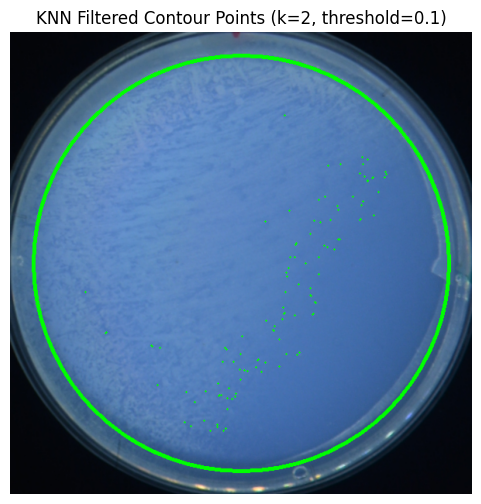

In [95]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

k = 2  # Number of nearest neighbors to consider
knn_threshold = 0.1  # Max average distance to neighbors (adjust as needed)

# Apply KNN
nbrs = NearestNeighbors(n_neighbors=k + 1).fit(radius_filtered_points)
distances, _ = nbrs.kneighbors(radius_filtered_points)

# Exclude the first column (distance to itself is 0)
mean_distances = distances[:, 1:].mean(axis=1)

# Mask for valid (non-isolated) points
knn_mask = mean_distances < knn_threshold
final_filtered_points = radius_filtered_points[knn_mask]

# Visualize on original cropped image (for reference)
knn_img = cropped_image.copy()
for pt in final_filtered_points:
    cv2.circle(knn_img, tuple(np.round(pt).astype(int)), 1, (0, 255, 0), -1)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(knn_img, cv2.COLOR_BGR2RGB))
plt.title(f"KNN Filtered Contour Points (k={k}, threshold={knn_threshold})")
plt.axis('off')
plt.show()

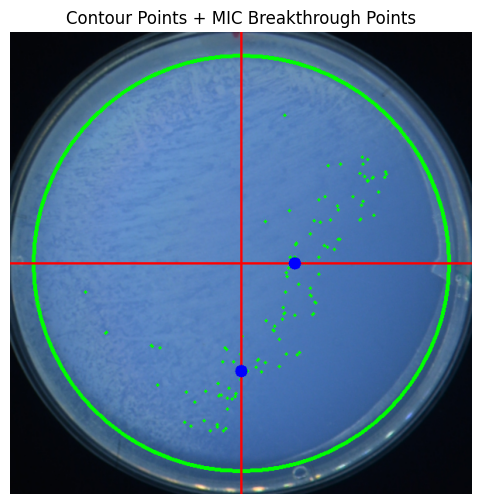

MIC_x: 17.98 µg/mL
MIC_y: 1.49 g/L


In [96]:
#TEST: OVERLAY MIC ONTO CONTOUR POINTS

# Configuration
drug_direction_x = 'right'  # or 'left'
drug_direction_y = 'top'    # or 'bottom'
tolerance = 20

# Setup
overlay_img = cropped_image.copy()
total_width = cropped_image.shape[1]
total_height = cropped_image.shape[0]
mid_y = total_height // 2
mid_x = total_width // 2

# Draw all final contour points
for pt in final_filtered_points:
    cv2.circle(overlay_img, tuple(pt.astype(int)), 2, (0, 255, 0), -1)  # green points

# Draw MIC midlines
cv2.line(overlay_img, (0, mid_y), (total_width, mid_y), (0, 0, 255), 2)   # horizontal (x MIC)
cv2.line(overlay_img, (mid_x, 0), (mid_x, total_height), (0, 0, 255), 2)  # vertical (y MIC)

# --- MIC X Calculation ---
contour_points_x = np.vstack(final_filtered_points).squeeze()
midline_points_x = contour_points_x[np.abs(contour_points_x[:, 1] - mid_y) < tolerance]

if len(midline_points_x) > 0:
    if drug_direction_x == 'right':
        breakthrough_x = np.median(midline_points_x[:, 0])  # Leftmost point
        MIC_value_x = (total_width - breakthrough_x) / total_width
    else:
        breakthrough_x = np.max(midline_points_x[:, 0])  # Rightmost
        MIC_value_x = breakthrough_x / total_width
else:
    breakthrough_x = np.min(contour_points_x[:, 0])
    MIC_value_x = (total_width - breakthrough_x) / total_width

cv2.circle(overlay_img, (int(breakthrough_x), mid_y), 8, (255, 0, 0), -1)

# --- MIC Y Calculation ---
contour_points_y = np.vstack(final_filtered_points).squeeze()
midline_points_y = contour_points_y[np.abs(contour_points_y[:, 0] - mid_x) < tolerance]

if len(midline_points_y) > 0:
    if drug_direction_y == 'top':
        breakthrough_y = np.median(midline_points_y[:, 1])

        MIC_value_y = (total_height - breakthrough_y) / total_height
    else:
        breakthrough_y = np.max(midline_points_y[:, 1])
        MIC_value_y = breakthrough_y / total_height
else:
    breakthrough_y = np.min(contour_points_y[:, 1])
    MIC_value_y = (total_height - breakthrough_y) / total_height

cv2.circle(overlay_img, (mid_x, int(breakthrough_y)), 8, (255, 0, 0), -1)

# Show results
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.title("Contour Points + MIC Breakthrough Points")
plt.axis('off')
plt.show()

# Optional: Convert to ug/mL
max_conc_x = 29.2
max_conc_y = 5.6
mic_x = (1 - MIC_value_x) * max_conc_x
mic_y = MIC_value_y * max_conc_y

print(f"MIC_x: {mic_x:.2f} µg/mL")
print(f"MIC_y: {mic_y:.2f} g/L")

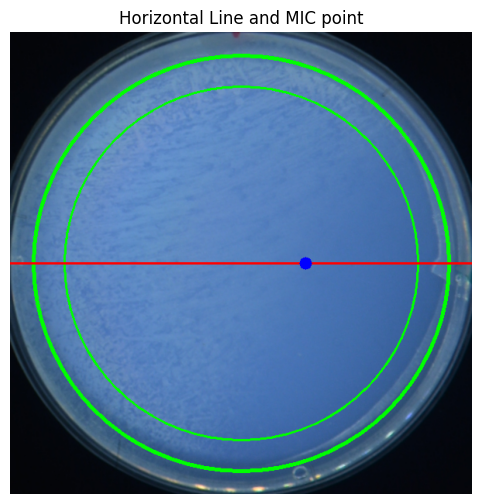

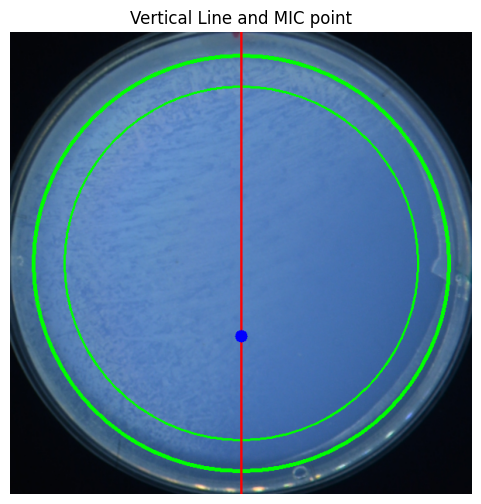

MIC_x: 10.53 µg/mL
MIC_y: 9.99 µg/mL


In [97]:
# Define midlines and tolerance (in pixels)
mid_y = cropped_image.shape[0] // 2
mid_x = cropped_image.shape[1] // 2
tolerance = 2

# --- HORIZONTAL MIC CALCULATION (for drug coming from right) ---
horizontal_line_img = reduced_contour_img.copy()
cv2.line(horizontal_line_img, (0, mid_y), (cropped_image.shape[1], mid_y), (0,0,255), 2)

contour_points_x = np.vstack(final_filtered_points).squeeze()
# Filter based on Y-coordinate being close to mid_y (should be row/midline)
midline_points_x = contour_points_x[np.abs(contour_points_x[:, 1] - mid_y) < tolerance]

if len(midline_points_x) > 0:
    breakthrough_x = np.max(midline_points_x[:, 0])  # leftmost point is breakthrough
else:
    breakthrough_x = np.min(contour_points_x[:, 0])

MIC_position_x = breakthrough_x
total_width = cropped_image.shape[1]

cv2.circle(horizontal_line_img, (MIC_position_x, mid_y), 8, (255, 0, 0), -1)
show_image(horizontal_line_img, "Horizontal Line and MIC point")

MIC_value_x = (total_width - MIC_position_x) / total_width  # assuming drug from right


# --- VERTICAL MIC CALCULATION (for inhibitor from top) ---
vertical_line_img = reduced_contour_img.copy()
cv2.line(vertical_line_img, (mid_x, 0), (mid_x, cropped_image.shape[0]), (0,0,255), 2)

contour_points_y = np.vstack(final_filtered_points).squeeze()
# Filter based on X-coordinate being close to mid_x (should be column/midline)
midline_points_y = contour_points_y[np.abs(contour_points_y[:, 0] - mid_x) < tolerance]

if len(midline_points_y) > 0:
    breakthrough_y = np.min(midline_points_y[:, 1])  # topmost point is breakthrough
else:
    breakthrough_y = np.min(contour_points_y[:, 1])

MIC_position_y = breakthrough_y
total_height = cropped_image.shape[0]

cv2.circle(vertical_line_img, (mid_x, MIC_position_y), 8, (255, 0, 0), -1)
show_image(vertical_line_img, "Vertical Line and MIC point")

MIC_value_y = (total_height - MIC_position_y) / total_height  # assuming drug from top

# --- Calculate concentration-based MICs ---
max_conc_x = 29.2  # µg/mL
max_conc_y = 29.2  # µg/mL
mic_x = MIC_value_x * max_conc_x
mic_y = MIC_value_y * max_conc_y

print(f"MIC_x: {mic_x:.2f} µg/mL")
print(f"MIC_y: {mic_y:.2f} µg/mL")

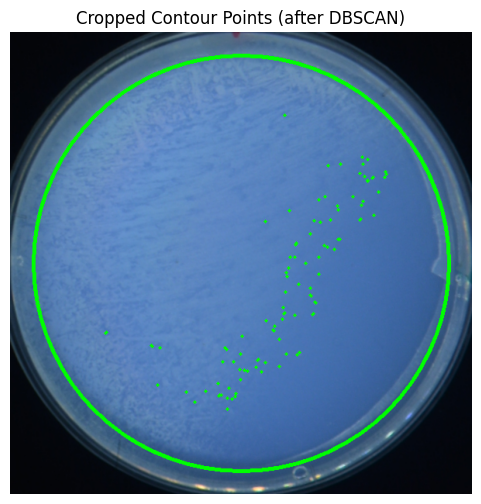

In [98]:
# Assume final_filtered_points already exists

# Get center
img_height, img_width = cropped_image.shape[:2]
center_x = img_width // 2
center_y = img_height // 2

# Define the side length of the square (you can adjust 0.65)
crop_ratio = 0.65
crop_size = int(crop_ratio * min(center_x, center_y))

# Define square boundaries
x_min = center_x - crop_size
x_max = center_x + crop_size
y_min = center_y - crop_size
y_max = center_y + crop_size

# Mask to select only points inside the square
inside_square_mask = (
    (final_filtered_points[:, 0] >= x_min) & (final_filtered_points[:, 0] <= x_max) &
    (final_filtered_points[:, 1] >= y_min) & (final_filtered_points[:, 1] <= y_max)
)

# Final cropped points
cropped_filtered_points = final_filtered_points[inside_square_mask]

# (Optional) Visualize it
overlay_img = cropped_image.copy()
for pt in cropped_filtered_points:
    cv2.circle(overlay_img, tuple(pt.astype(int)), 2, (0, 255, 0), -1)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.title("Cropped Contour Points (after DBSCAN)")
plt.axis('off')
plt.show()


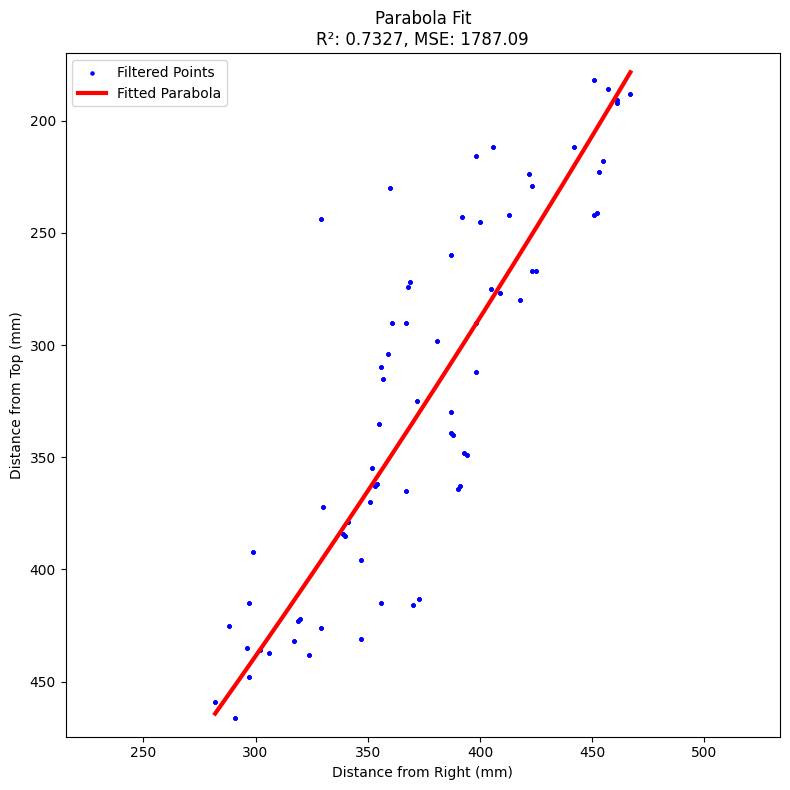

Quadratic coefficient (a): -0.0007 → no significant curvature
Linear coefficient (b): -0.9934 → negative linear shift (reducing effect)
Intercept (c): 802.8660
Equation of fitted parabola: y = -0.0007x² + -0.9934x + 802.8660
Overall interaction type: primarily linear interaction (negative linear shift (reducing effect))
Fit statistics: R²: 0.7327, MSE: 1787.09


In [99]:
#Parabolic Curve Fitting
x_coords = cropped_filtered_points[:, 0]
y_coords = cropped_filtered_points[:, 1]

# Filter out extreme values along both axes
x_mask = (x_coords > np.percentile(x_coords, 15)) & (x_coords < np.percentile(x_coords, 95))
y_mask = (y_coords > np.percentile(y_coords, 5)) & (y_coords < np.percentile(y_coords, 95))
mask = x_mask & y_mask

x_filtered = x_coords[mask]
y_filtered = y_coords[mask]


# Fit parabola using RANSAC + Ridge Regression
model = make_pipeline(
    PolynomialFeatures(2),
    RANSACRegressor(
        min_samples=0.5,
        residual_threshold=10,
        random_state=42
    )
)
model.fit(x_filtered[:, np.newaxis], y_filtered)

# Generate smooth curve to plot
x_curve = np.linspace(np.min(x_filtered), np.max(x_filtered), 500)
y_curve = model.predict(x_curve[:, np.newaxis])

# Compute metrics
r2 = r2_score(y_filtered, model.predict(x_filtered[:, np.newaxis]))
mse = mean_squared_error(y_filtered, model.predict(x_filtered[:, np.newaxis]))

# Set up rounded axes with padding
x_min = np.floor(np.min(x_filtered) / 50) * 50
x_max = np.ceil(np.max(x_filtered) / 50) * 50
y_min = np.floor(np.min(y_filtered) / 50) * 50
y_max = np.ceil(np.max(y_filtered) / 50) * 50

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(x_filtered, y_filtered, s=5, color='blue', label='Filtered Points')
plt.plot(x_curve, y_curve, color='red', linewidth=3, label='Fitted Parabola')

plt.title(f'Parabola Fit\nR²: {r2:.4f}, MSE: {mse:.2f}')
plt.xlabel("Distance from Right (mm)")
plt.ylabel("Distance from Top (mm)")
plt.legend()

# Axis fixes
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(np.arange(x_min, x_max + 1, 50))
plt.yticks(np.arange(y_min, y_max + 1, 50))
plt.gca().invert_yaxis()  # To keep y = top-to-bottom
plt.axis('equal')         # Ensure circle-like shape consistency
plt.tight_layout()
plt.show()

# Print fitted equation + stats
coefs = model.named_steps['ransacregressor'].estimator_.coef_
intercept = model.named_steps['ransacregressor'].estimator_.intercept_

# Coefficients from model
coefs = model.named_steps['ransacregressor'].estimator_.coef_
intercept = model.named_steps['ransacregressor'].estimator_.intercept_
a = coefs[2]  # Quadratic
b = coefs[1]  # Linear
c= intercept
# Adjust thresholds if needed
quad_threshold = 1e-2
lin_threshold = 1e-3

# Inverted Y-axis interpretation
if abs(a) < quad_threshold:
    quad_interaction = "no significant curvature"
elif a > 0:
    quad_interaction = "antagonistic curvature (umbrella-shaped)"  # ✅ inverted interpretation
else:
    quad_interaction = "synergistic curvature (valley-shaped)"     # ✅ inverted interpretation

# Linear term interpretation remains the same
if abs(b) < lin_threshold:
    lin_interaction = "no significant linear shift"
elif b > 0:
    lin_interaction = "positive linear shift (enhancing effect)"
else:
    lin_interaction = "negative linear shift (reducing effect)"

# Combined interpretation
if abs(a) < quad_threshold and abs(b) < lin_threshold:
    interaction_type = "purely additive (no significant interaction)"
elif abs(a) < quad_threshold:
    interaction_type = f"primarily linear interaction ({lin_interaction})"
elif abs(b) < lin_threshold:
    interaction_type = f"primarily quadratic interaction ({quad_interaction})"
else:
    interaction_type = f"mixed interaction ({quad_interaction}, {lin_interaction})"

# Print corrected interpretation
print(f"Quadratic coefficient (a): {a:.4f} → {quad_interaction}")
print(f"Linear coefficient (b): {b:.4f} → {lin_interaction}")
print(f"Intercept (c): {intercept:.4f}")
print(f"Equation of fitted parabola: y = {a:.4f}x² + {b:.4f}x + {intercept:.4f}")
print(f"Overall interaction type: {interaction_type}")
print(f"Fit statistics: R²: {r2:.4f}, MSE: {mse:.2f}")

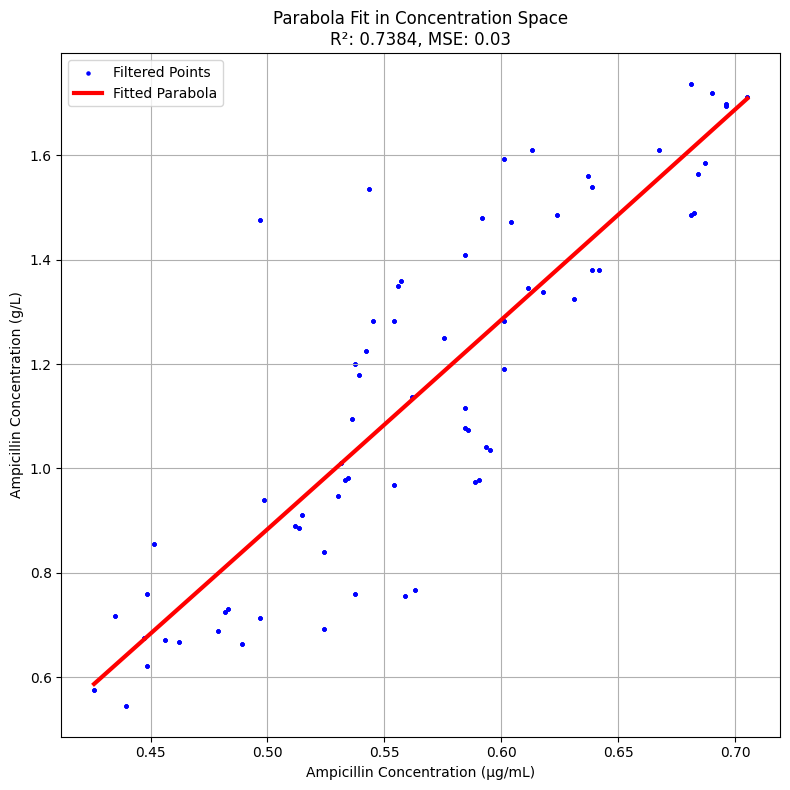


--- Parabola Fit in Concentration Space ---
Equation: y = 0.0899x² + 3.9160x + -1.0970
R²: 0.7384
MSE: 0.03
Quadratic term (a): 0.0899 → synergistic (valley-shaped)
Linear term (b): 3.9160 → increasing shift with concentration


In [100]:
# Define max concentrations and image dimensions
max_conc_x = 0.9  # e.g., Mecillinam
max_conc_y = 2.5   # e.g., NaCl
img_width = cropped_image.shape[1]
img_height = cropped_image.shape[0]

# Transform coordinates to concentration space
x_conc = x_filtered / img_width * max_conc_x
y_conc = (img_height - y_filtered) / img_height * max_conc_y

# Fit model in concentration space
model.fit(x_conc[:, np.newaxis], y_conc)
x_curve_conc = np.linspace(np.min(x_conc), np.max(x_conc), 500)
y_curve_conc = model.predict(x_curve_conc[:, np.newaxis])

# Plot
#plt.figure(figsize=(8, 8))
#plt.scatter(x_conc, y_conc, s=5, color='blue', label='Filtered Points')
#plt.plot(x_curve_conc, y_curve_conc, color='red', linewidth=3, label='Fitted Parabola')
#plt.xlabel("Ampicillin Concentration (µg/mL)")
#plt.ylabel("Chloramphenicol Concentration (µg/mL)")
#plt.title(f'Parabola Fit in Concentration Space\nR²: {r2_score(y_conc, model.predict(x_conc[:, np.newaxis])):.4f}')
#plt.gca().invert_yaxis()  # Top of plate = high salt
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()
from sklearn.metrics import r2_score, mean_squared_error

# Define max concentrations and image dimensions
#max_conc_x = 29.2  # Mecillinam
#max_conc_y = 29.2   # NaCl
#img_width = cropped_image.shape[1]
#img_height = cropped_image.shape[0]

# Transform coordinates to concentration space
#x_conc = (img_width - x_filtered) / img_width * max_conc_x
#y_conc = y_filtered / img_height * max_conc_y

 #Fit model in concentration space
model.fit(x_conc[:, np.newaxis], y_conc)
x_curve_conc = np.linspace(np.min(x_conc), np.max(x_conc), 500)
y_curve_conc = model.predict(x_curve_conc[:, np.newaxis])

# Evaluate model
y_pred = model.predict(x_conc[:, np.newaxis])
r2_conc = r2_score(y_conc, y_pred)
mse_conc = mean_squared_error(y_conc, y_pred)

 #Get coefficients
coefs = model.named_steps['ransacregressor'].estimator_.coef_
intercept = model.named_steps['ransacregressor'].estimator_.intercept_
a = coefs[2]  # Quadratic term
b = coefs[1]  # Linear term
c = intercept

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x_conc, y_conc, s=5, color='blue', label='Filtered Points')
plt.plot(x_curve_conc, y_curve_conc, color='red', linewidth=3, label='Fitted Parabola')
plt.xlabel("Ampicillin Concentration (µg/mL)")
plt.ylabel("Ampicillin Concentration (g/L)")
plt.title(f'Parabola Fit in Concentration Space\nR²: {r2_conc:.4f}, MSE: {mse_conc:.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()#
plt.show()

# Report equation and stats
print(f"\n--- Parabola Fit in Concentration Space ---")
print(f"Equation: y = {a:.4f}x² + {b:.4f}x + {c:.4f}")
print(f"R²: {r2_conc:.4f}")
print(f"MSE: {mse_conc:.2f}")

# Optional interpretation
quad_threshold = 1e-5
lin_threshold = 1e-3
if abs(a) < quad_threshold:
    quad_interaction = "no significant curvature"
elif a > 0:
    quad_interaction = "synergistic (valley-shaped)"
else:
    quad_interaction = "antagonistic (umbrella-shaped)"

if abs(b) < lin_threshold:
    lin_interaction = "no significant linear trend"
elif b > 0:
    lin_interaction = "increasing shift with concentration"
else:
    lin_interaction = "decreasing shift with concentration"

print(f"Quadratic term (a): {a:.4f} → {quad_interaction}")
print(f"Linear term (b): {b:.4f} → {lin_interaction}")

<ipython-input-24-84ebd978461f>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colormap = plt.cm.get_cmap("tab10", np.max(labels) + 2)


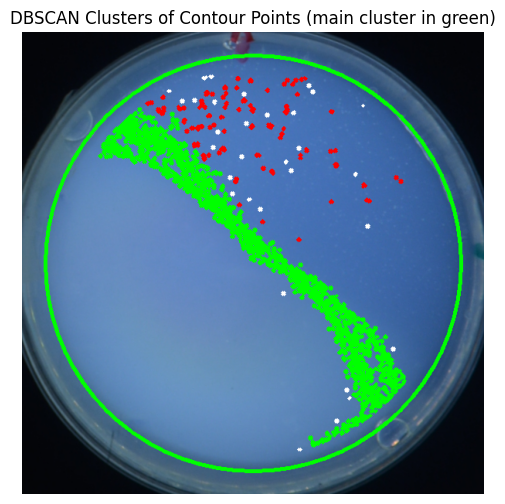

In [ ]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assume: `radius_filtered_points` and `cropped_image` already exist from earlier blocks

# Run DBSCAN on filtered contour points
eps = 5
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples).fit(radius_filtered_points)
labels = db.labels_

# Get largest cluster label (excluding noise)
unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)
if len(unique_labels) == 0:
    print("No clusters found with DBSCAN.")
    main_cluster_label = None
else:
    main_cluster_label = unique_labels[np.argmax(counts)]

# Create colored overlay of all clusters
color_img = cropped_image.copy()
cluster_colormap = plt.cm.get_cmap("tab10", np.max(labels) + 2)

for i, point in enumerate(radius_filtered_points):
    label = labels[i]
    if label == -1:
        color = (255, 255, 255)  # white for noise
    elif label == main_cluster_label:
        color = (0, 255, 0)  # green for main cluster
    else:
        color = (0, 0, 255) #red for all other clusters
    cv2.circle(color_img, tuple(point.astype(int)), 2, color, -1)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))
plt.title(f"DBSCAN Clusters of Contour Points (main cluster in green)")
plt.axis("off")
plt.show()


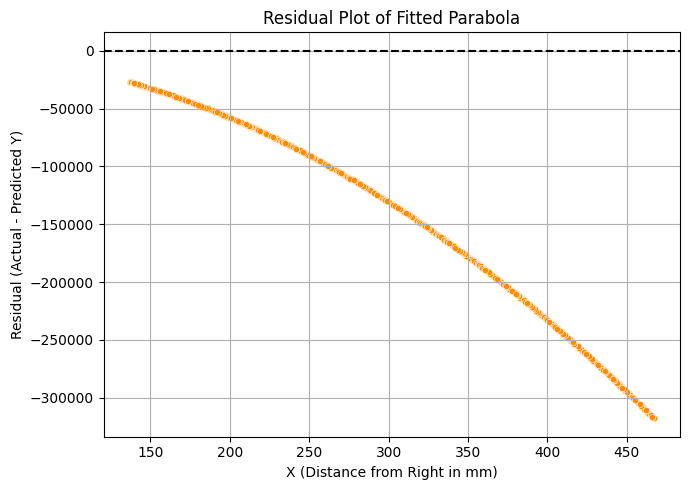

NameError: name 'y_filtered_dbscan' is not defined

In [ ]:
# Residual Plot Block
import seaborn as sns

# After fitting the model
predicted_y = model.predict(x_filtered[:, np.newaxis])
residuals = y_filtered - predicted_y

plt.figure(figsize=(7, 5))
sns.scatterplot(x=x_filtered, y=residuals, color='darkorange', s=20)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual Plot of Fitted Parabola")
plt.xlabel("X (Distance from Right in mm)")
plt.ylabel("Residual (Actual - Predicted Y)")
plt.grid(True)
plt.tight_layout()
plt.show()

residuals_dbscan = y_filtered_dbscan - y_pred_dbscan
residuals_knn = y_filtered_knn - y_pred_knn

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x_filtered_dbscan, residuals_dbscan, color='royalblue', label="DBSCAN")
plt.axhline(0, linestyle='--', color='gray')
plt.title("DBSCAN Residuals")
plt.xlabel("X")
plt.ylabel("Residual")

plt.subplot(1,2,2)
plt.scatter(x_filtered_knn, residuals_knn, color='firebrick', label="KNN")
plt.axhline(0, linestyle='--', color='gray')
plt.title("KNN Residuals")
plt.xlabel("X")

plt.tight_layout()
plt.show()